# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
# seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

185



# Data preparation

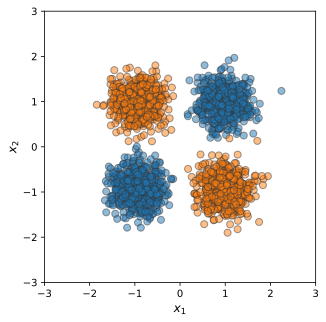

In [2]:
# data_noise = 0.05
data_noise = 0.15
plotlim = [-3, 3]
subfolder = 'traj_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('xor', noise = data_noise, plotlim = plotlim, random_state = seed, label = 'vector')


In [3]:
for x_batch, y_batch in dataloader:
    print(x_batch, y_batch)
    print(y_batch[0:20].size())
    
    print(len(y_batch.shape) > 1)
    break

tensor([[-0.8840, -0.8391],
        [ 1.3881,  0.7334],
        [ 1.0175,  1.2901],
        [-1.1634, -0.9472],
        [-1.4400,  1.2245],
        [-0.8058,  1.1609],
        [ 1.0444,  0.6964],
        [-0.8022,  0.8583],
        [-0.6264,  1.2181],
        [ 1.0746, -0.7190],
        [ 1.0101,  0.8394],
        [ 0.7877, -1.0854],
        [ 1.2806, -0.7093],
        [ 0.9852,  1.7638],
        [-1.3265, -0.9937],
        [-0.8328,  1.1375],
        [ 1.2695, -1.0965],
        [ 0.9186, -0.9263],
        [-0.6864,  1.0920],
        [ 0.6858,  0.9794],
        [ 1.2458,  1.0961],
        [-0.8740, -1.0619],
        [ 0.7178,  0.8434],
        [ 1.2081, -1.1322],
        [ 1.4066,  0.6501],
        [-0.9771,  0.9537],
        [ 1.2731, -1.8236],
        [-0.9090,  1.1824],
        [-0.2542,  0.8226],
        [-0.9550, -0.7732],
        [ 1.1148, -0.6780],
        [ 1.1738, -0.7480],
        [ 1.5812, -0.7962],
        [-1.0095, -0.5028],
        [-1.5387,  1.3830],
        [-0.4790, -0

## Model dynamics

In [4]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE, NeuralODE_justflow

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 6, 6
bound = 0.


fp = False


cross_entropy = False #this leads to squared loss in the training
turnpike = False

non_linearity = 'tanh'#'relu' # #
architecture = 'inside' #outside
layers = 2 #if i use some custom dynamics


## Training and generating level sets

In [5]:
import torch.nn as nn

activations = {'tanh': nn.Tanh(),
                'relu': nn.ReLU(),
                'sigmoid': nn.Sigmoid(),
                'leakyrelu': nn.LeakyReLU(negative_slope=0.25, inplace=True)
}
architectures = {'inside': -1, 'outside': 0, 'bottleneck': 1}


"""Define an autonomous ODE dynamic"""

class Dynamics_autonomous(nn.Module):
    """
    The nonlinear, right hand side $f(x(t)) of a neural ODE.
    """
    def __init__(self, device, data_dim, hidden_dim, augment_dim=0, 
                non_linearity='tanh', architecture='inside', T=10, layers=10):
        super(Dynamics_autonomous, self).__init__()
        self.device = device
        self.augment_dim = augment_dim
        self.data_dim = data_dim
        self.input_dim = data_dim + augment_dim
        self.hidden_dim = hidden_dim

        if non_linearity not in activations.keys() or architecture not in architectures.keys():
            raise ValueError("Activation function or architecture not found. Please reconsider.")
        
        self.non_linearity = activations[non_linearity]
        self.architecture = architectures[architecture]
        self.T = T
        self.layers = layers
       
        

        blocks1 = []
        for _ in range(self.layers):
            blocks1.append(nn.Linear(self.input_dim, self.hidden_dim))
            blocks1.append(nn.Tanh())

        self.layer_functions1 = nn.Sequential(*blocks1)
        
        blocks2 = []
        for _ in range(self.layers):
            blocks2.append(nn.Linear(self.input_dim, self.hidden_dim))
            blocks2.append(nn.Tanh())

        self.layer_functions2 = nn.Sequential(*blocks2)
        
        
        # if self.architecture > 0:
        #     ##-- R^{d_aug} -> R^{d_hid} layer -- 
        #     blocks1 = [nn.Linear(self.input_dim, hidden_dim) for _ in range(self.layers)]
        #     self.fc1_time = nn.Sequential(*blocks1) 
        #     ##-- R^{d_hid} -> R^{d_aug} layer --
        #     blocks3 = [nn.Linear(hidden_dim, self.input_dim) for _ in range(self.layers)]
        #     self.fc3_time = nn.Sequential(*blocks3)
        # else:
        #     ##-- R^{d_hid} -> R^{d_hid} layer --
        #     blocks = [nn.Linear(hidden_dim, hidden_dim) for _ in range(self.layers)]
        #     self.fc2_time = nn.Sequential(*blocks)
        
    def forward(self, t, x):
        """
        There is no time variable active in this autonomous version
        
        """
        if t < self.T/2:
            out = self.layer_functions1(x)
        else:
            out = self.layer_functions2(x)

        return out
    

    
dynamics = Dynamics_autonomous(device, data_dim, hidden_dim, augment_dim, non_linearity, architecture, T = T, layers = layers)

In [6]:

num_epochs = 80 #number of optimization runs in which the dataset is used for gradient decent
l2_factor = 0.02
eps = 0.
# dynamics = False

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE_justflow(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy, dynamics = dynamics)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE_justflow(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [7]:
from models.training import doublebackTrainer
#!!added l2 factor
trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, l2_factor=l2_factor) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 19.317

Iteration 10/38
Loss: 15.818

Iteration 20/38
Loss: 16.626

Iteration 30/38
Loss: 14.676
Epoch 1: 16.774

Iteration 0/38
Loss: 13.686

Iteration 10/38
Loss: 15.734

Iteration 20/38
Loss: 12.608

Iteration 30/38
Loss: 15.453
Epoch 2: 13.922

Iteration 0/38
Loss: 11.989

Iteration 10/38
Loss: 11.551

Iteration 20/38
Loss: 12.812

Iteration 30/38
Loss: 8.718
Epoch 3: 11.208

Iteration 0/38
Loss: 7.474

Iteration 10/38
Loss: 12.687

Iteration 20/38
Loss: 8.066

Iteration 30/38
Loss: 11.805
Epoch 4: 8.730

Iteration 0/38
Loss: 10.021

Iteration 10/38
Loss: 5.142

Iteration 20/38
Loss: 8.299

Iteration 30/38
Loss: 4.725
Epoch 5: 6.973

Iteration 0/38
Loss: 4.543

Iteration 10/38
Loss: 4.962

Iteration 20/38
Loss: 5.173

Iteration 30/38
Loss: 6.263
Epoch 6: 5.527

Iteration 0/38
Loss: 4.003

Iteration 10/38
Loss: 4.685

Iteration 20/38
Loss: 4.739

Iteration 30/38
Loss: 4.789
Epoch 7: 4.541

Iteration 0/38
Loss: 4.510

Iteration 10/38
Loss: 3.725

Iteration 20/38

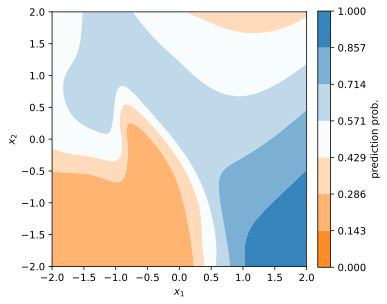

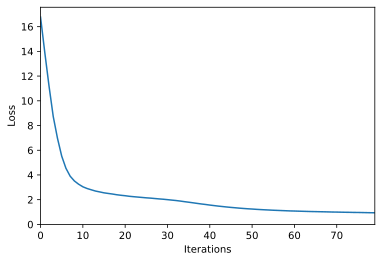

In [8]:
from plots.plots import classification_levelsets
classification_levelsets(anode)
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

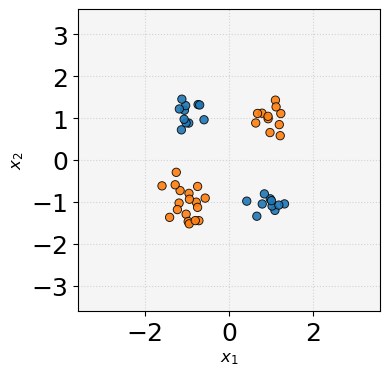

In [9]:
from plots.gifs import trajectory_gif
from IPython.display import Image

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 3, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
display(traj)

In [10]:
trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, db_type='l2') 
# trainer_rnode.train(dataloader, num_epochs)

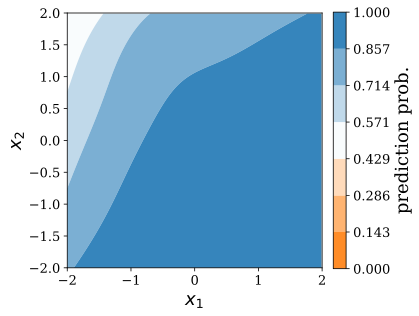

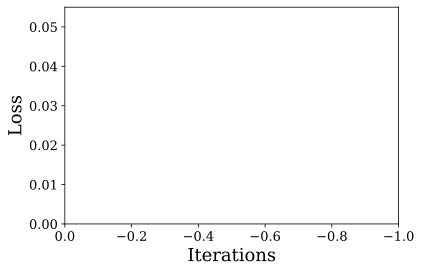

In [11]:
from plots.plots import classification_levelsets
classification_levelsets(rnode)
plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

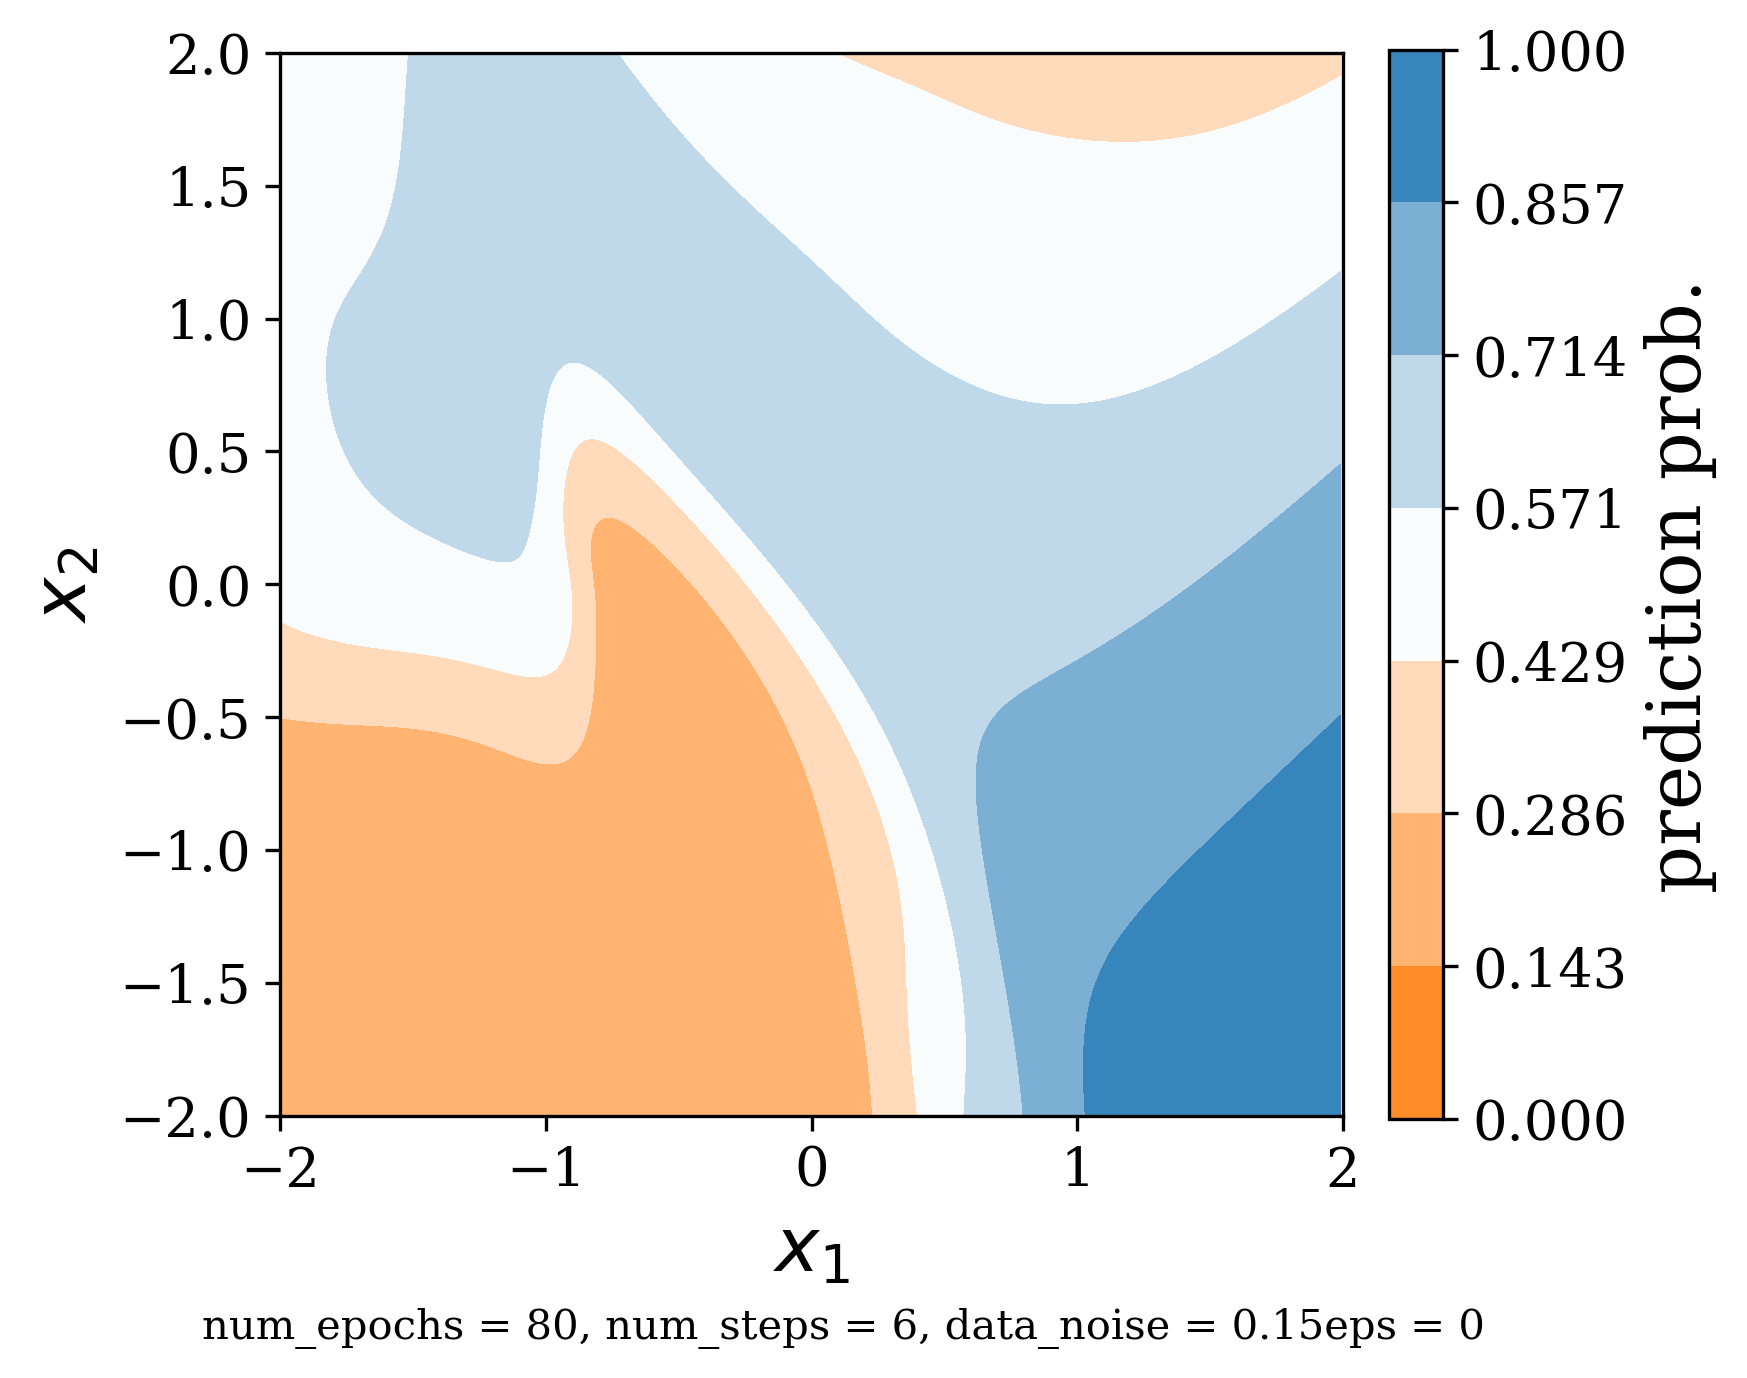

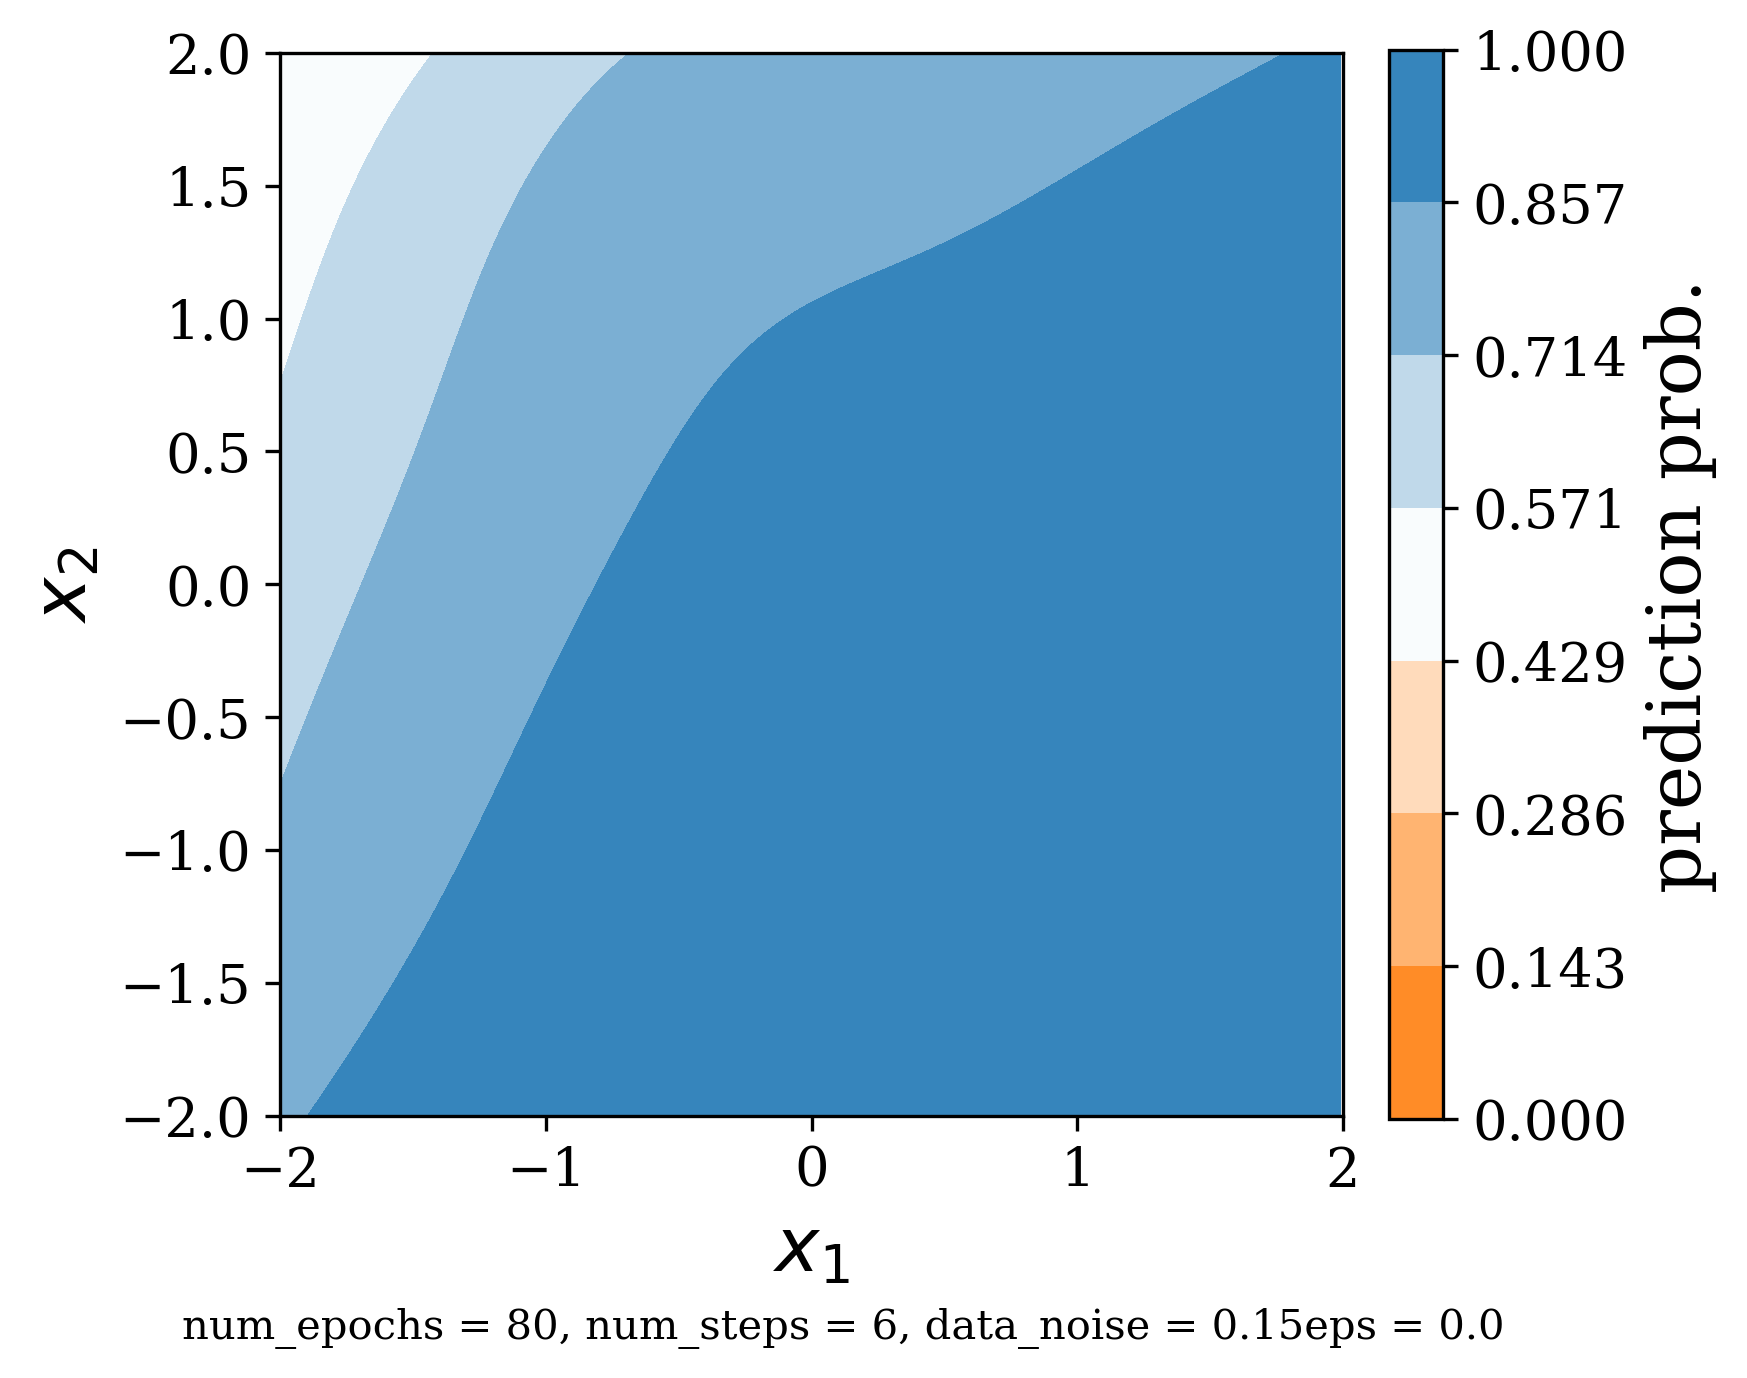

In [12]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
footnote = f'{num_epochs = }, {num_steps = }, {data_noise = }'
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base, footnote = footnote + 'eps = 0')
classification_levelsets(rnode, fig_name_base + '_rob', footnote = footnote + f'{eps = }')
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = fig_name_base + '_rob.png', width = 400)

display(img1,img2)

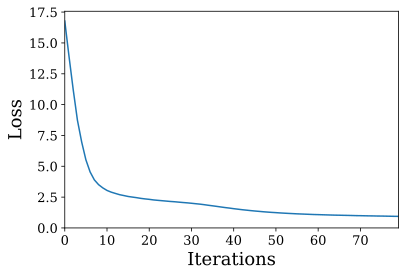

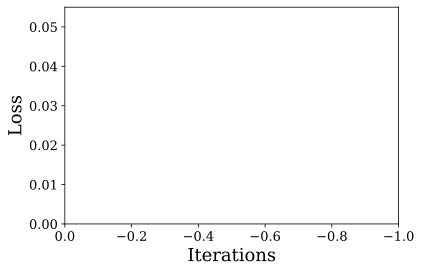

In [13]:
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [14]:
for X_viz, y_viz in dataloader_viz:
    X_viz = X_viz[0:5]
    break

trajectories = anode.flow.trajectory(X_viz, 10).detach()
print(X_viz)
print(trajectories.size()) #time is in the first coordinate




tensor([[ 0.9039,  1.0869],
        [-1.1428,  1.0915],
        [-1.4875,  0.9638],
        [-1.1563, -1.0229],
        [-0.8699,  1.5528]])
torch.Size([10, 5, 2])


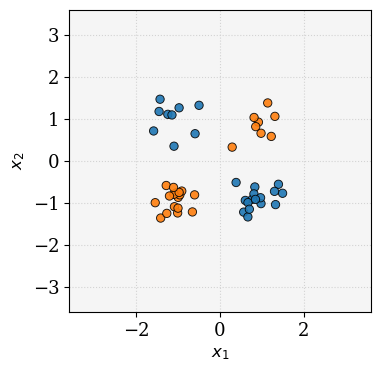

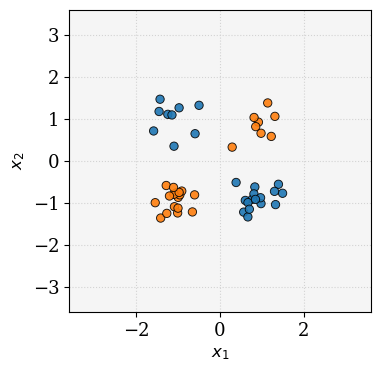

In [15]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 3, dpi = 100)
    trajectory_gif(rnode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 3, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

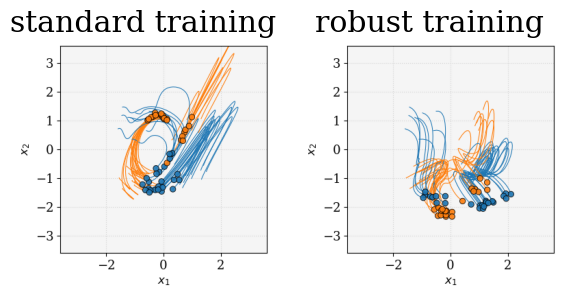

In [16]:
from IPython.display import Image
from plots.plots import comparison_plot
# traj = Image(filename="trajectory19.png", retina = True)
# rtraj = Image(filename="trajectory_db19.png", retina = True)
# display(traj, rtraj)

comparison_plot("trajectory39.png", 'standard training', "trajectory_db39.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

I want to visualize the separation boundary in the final linear layer.